<a href="https://www.kaggle.com/code/philper/coffeeshop-location-recommender?scriptVersionId=151066223" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Coffeeshop Location Recommender for Philadelphia

## Datasets:
- Parks (PPR_Properties.deojson) https://opendataphilly.org/datasets/ppr-properties/
- Universities (Universities_colleges.geojson) https://opendataphilly.org/datasets/philadelphia-universities-and-colleges/
- Bus stops (Bus_Stops_(Fall_2023).geojson) https://gis-septa.hub.arcgis.com/datasets/SEPTA::bus-stops-fall-2023/explore?location=40.072734%2C-75.294448%2C10.54
- Train stations (Regional_Rail_Stations.geojson) https://gis-septa.hub.arcgis.com/datasets/SEPTA::regional-rail-stations/explore
- Yelp dataset https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
- Population age/sex (phillyagesex_ACSST5Y2020.S0101-Data.csv) https://data.census.gov/table/ACSST1Y2022.S0101?q=Age+and+Sex
- Population household income (phillyhouseholdincome_ACSST5Y2020.S2503-Data.csv) https://data.census.gov/table/ACSST5Y2020.S2503?q=2020+Median+Household+Income
- Population density (tl_2020_42_tract20.shp) https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/42_PENNSYLVANIA/42/

## Imports

In [ ]:
!pip install geojsoncontour --quiet
import json
import folium
import time
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster, MousePosition
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import branca.colormap as cmp
from pylab import *
import geoplot
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import branca
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage

## Load Data

#### Other Data

In [ ]:
projected_crs = 'EPSG:6564'

# Load park data
park_gdf = gpd.read_file('/kaggle/input/philadelphia-data/PPR_Properties.geojson')
park_gdf = park_gdf.to_crs(projected_crs) # Project in plain coordinate system

# Load university data
university_gdf = gpd.read_file('/kaggle/input/philadelphia-data/Universities_Colleges.geojson')
university_gdf = university_gdf.to_crs(projected_crs) # Project in plain coordinate system

# Load university data
# streets_gdf = gpd.read_file('/kaggle/input/philadelphia-data/CompleteStreets.geojson')
# streets_gdf = streets_gdf.to_crs(projected_crs) # Project in plain coordinate system

# Load bus stop data
bus_gdf = gpd.read_file('/kaggle/input/philadelphia-data/Bus_Stops_(Fall_2023).geojson')
bus_gdf = bus_gdf.to_crs(projected_crs) # Project in plain coordinate system

# Load train station data
train_gdf = gpd.read_file('/kaggle/input/philadelphia-data/Regional_Rail_Stations.geojson')
train_gdf = train_gdf.to_crs(projected_crs) # Project in plain coordinate system

#### Yelp Data

In [ ]:
# Load the Yelp dataset into a DataFrame
def yelp_json_to_df(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]
    return pd.DataFrame(data)

In [ ]:
# Load yelp business data
business_df = yelp_json_to_df("/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json")
business_df = business_df[business_df['city'] == 'Philadelphia']
business_df.dropna(subset=['categories'], inplace =True)
business_gdf = gpd.GeoDataFrame(
    business_df, geometry=gpd.points_from_xy(business_df.longitude, business_df.latitude), crs="WGS84"
)
business_gdf = business_gdf.to_crs(projected_crs)
coffee_gdf = business_gdf[business_gdf['categories'].str.contains('Coffee & Tea')].reset_index().copy(deep=True)
#coffee_gdf = gpd.GeoDataFrame(
#    coffee_df, geometry=gpd.points_from_xy(coffee_df.longitude, coffee_df.latitude), crs="WGS84"
#)
#coffee_gdf = coffee_gdf.to_crs(projected_crs) # Project in plain coordinate system
# coffee_gdf without starbucks
coffee_wo_starbucks_gdf = coffee_gdf[~coffee_gdf['name'].str.contains('tarbucks')].reset_index().copy(deep=True)
# only the starbucks shops in coffee_gdf
starbucks_gdf = coffee_gdf[coffee_gdf['name'].str.contains('tarbucks')].reset_index().copy(deep=True) # tarbucks to include lower and upper case S

#### Demographical Data

In [ ]:
# Define a function to clip and scale the data
def robust_scaler(column, lower_q, upper_q):
    # Calculate the quantile values
    lower_bound = column.quantile(lower_q)
    upper_bound = column.quantile(upper_q)
    # Clip the column values
    column_clipped = column.clip(lower_bound, upper_bound)
    # Scale the clipped data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(column_clipped.values.reshape(-1, 1)).flatten()
    # Assign 0 to the values below the lower bound and 1 to those above the upper bound
    scaled_data_full_range = np.where(column < lower_bound, 0, np.where(column > upper_bound, 1, scaled_data))
    return scaled_data_full_range

def transform_census_data(census_gdf, age_df, income_df, plot=False):
    
    # Filtering of GeoData
    # Filter the GeoDataFrame for Philadelphia County (FIPS code '101')
    census_gdf = census_gdf[census_gdf['COUNTYFP20'] == '101'].copy()

    # Calculate and assign population density to census tracts
    # Convert the area from square meters to square kilometers for better readability
    census_gdf['land_area_km2'] = census_gdf['ALAND20'] / 1e6
    # Remove the '1400000US' prefix from the 'GEO_ID' column in the population DataFrame
    age_df['GEO_ID'] = age_df['GEO_ID'].str.replace('1400000US', '')
    # Merge the population data with the GeoDataFrame based on the 'GEOID20' column
    census_gdf = census_gdf.merge(age_df, left_on='GEOID20', right_on='GEO_ID')
    # Convert 'S1010_C01_001E' to numeric (float) -> total population per census tract
    census_gdf['pop_total'] = census_gdf['S0101_C01_001E'].astype(float)
    # Calculate the population density (people per km²)
    census_gdf['pop_density'] = census_gdf['pop_total'] / census_gdf['land_area_km2']
    # Replace invalid pop_density values with NaN
    invalid_density_mask = (census_gdf['pop_density'] == 0) | (census_gdf['pop_density'] == float('inf')) | (census_gdf['pop_density'].isna())
    census_gdf.loc[invalid_density_mask, 'pop_density'] = float('nan')

    # Calculate and assign percentage of people between 10 and 34 to census tracts
    # Convert age group percentage columns to float, fill with NaN when non-numerical
    age_columns = ['S0101_C02_004E', 'S0101_C02_005E', 'S0101_C02_006E', 'S0101_C02_007E', 'S0101_C02_008E']
    for column in age_columns:
        age_df[column] = pd.to_numeric(age_df[column], errors='coerce')
    # Rename the columns
    age_group_names = {
        'S0101_C02_004E': 'pop_perc_10_14',
        'S0101_C02_005E': 'pop_perc_15_19',
        'S0101_C02_006E': 'pop_perc_20_24',
        'S0101_C02_007E': 'pop_perc_25_29',
        'S0101_C02_008E': 'pop_perc_30_44',
    }
    age_df.rename(columns=age_group_names, inplace=True)
    # Calculate the sum of all the age group percentages
    age_df['pop_young_perc'] = age_df[['pop_perc_10_14', 'pop_perc_15_19', 'pop_perc_20_24', 'pop_perc_25_29', 'pop_perc_30_44']].sum(axis=1)
    # Merge the new columsn with the GeoDataFrame
    age_df['GEO_ID'] = age_df['GEO_ID'].str.replace('1400000US', '')
    census_gdf = census_gdf.merge(
        age_df[['GEO_ID', 'pop_perc_10_14', 'pop_perc_15_19', 'pop_perc_20_24', 'pop_perc_25_29', 'pop_perc_30_44', 'pop_young_perc']],
        left_on='GEOID20',
        right_on='GEO_ID'
    )

    #Assign median household income to census tracts
    # Convert 'S2503_C01_013E' to numeric (float), which represents median household income, and fill with NaN when non-numerical
    income_df['S2503_C01_013E'] = pd.to_numeric(income_df['S2503_C01_013E'], errors='coerce')
    # Remove the '1400000US' prefix from the 'GEO_ID' column in the household income DataFrame
    income_df['GEO_ID'] = income_df['GEO_ID'].str.replace('1400000US', '')
    # Merge the household income data with the GeoDataFrame based on the 'GEOID20' column
    census_gdf = census_gdf.merge(
        income_df[['GEO_ID', 'S2503_C01_013E']],
        left_on='GEOID20',
        right_on='GEO_ID',
        how='left'  # Use 'left' to keep all rows from `census_gdf` even if there's no match in `income_df`
    )
    # Rename the income column for clarity
    census_gdf.rename(columns={'S2503_C01_013E': 'median_household_income'}, inplace=True)

    # Original quantiles for the normal scale (0.0, 1.0)
    original_lower_q = 0.0
    original_upper_q = 1.0

    # Quantiles for adjustment (determined by eye)
    lower_pop_density = 0.0
    upper_pop_density = 0.955
    lower_pop_young_perc = 0.05
    upper_pop_young_perc = 0.96
    lower_median_household_income = 0.0
    upper_median_household_income = 0.96

    # Define the columns to be scaled
    columns_to_scale = ['pop_density', 'pop_young_perc', 'median_household_income']

    # Apply the robust scaler with default quantiles for the original distributions
    for col in columns_to_scale:
        census_gdf[col + '_original_normalized'] = robust_scaler(census_gdf[col], original_lower_q, original_upper_q)

    # Apply the robust scaler with given quantiles for the adjusted distributions
    for col in columns_to_scale:
        lower_q = locals()[f'lower_{col}']
        upper_q = locals()[f'upper_{col}']
        census_gdf[col + '_normalized'] = robust_scaler(census_gdf[col], lower_q, upper_q)
    if plot:
        # Plotting the original distributions
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        colors = {'pop_density': 'green', 'pop_young_perc': 'red', 'median_household_income': 'blue'}
        for i, col in enumerate(columns_to_scale):
            axes[i].hist(census_gdf[col + '_original_normalized'], bins=20, color=colors[col], alpha=0.7)
            axes[i].set_title(f'Original Normalized {col} Distribution')

        # Improve layout and show/save plot
        plt.tight_layout()
        plt.savefig('original_distributions.png', dpi=300)
        plt.show()
    # After plotting, drop the original_normalized columns
    census_gdf = census_gdf.drop(columns=[col + '_original_normalized' for col in columns_to_scale])

    if plot:
        # Plotting the adjusted distributions
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        for i, col in enumerate(columns_to_scale):
            axes[i].hist(census_gdf[col + '_normalized'], bins=20, color=colors[col], alpha=0.7)
            axes[i].set_title(f'Adjusted Normalized {col} Distribution')

        # Improve layout and show/save plot
        plt.tight_layout()
        plt.savefig('adjusted_distributions.png', dpi=300)
        plt.show()

    # Calculate the average of the adjusted normalized columns and rename it to 'average'
    census_gdf['average'] = census_gdf[[col + '_normalized' for col in columns_to_scale]].mean(axis=1)

    # Scale this 'average' to be between 0 and 1 and rename it to 'normalized_average'
    scaler = MinMaxScaler()
    census_gdf['normalized_average'] = scaler.fit_transform(census_gdf[['average']])

    # Now remove the old 'normalized_average_scaled' if it exists
    # census_gdf.drop(columns=['normalized_average_scaled'], errors='ignore', inplace=True)

    # Define the columns to keep
    columns_to_keep = [
        'pop_density', 'pop_young_perc', 'median_household_income','pop_density_normalized', 'pop_young_perc_normalized', 'median_household_income_normalized','normalized_average', 'geometry'
    ]
    demography_gdf = census_gdf[columns_to_keep].copy(deep=True)
    return demography_gdf


In [ ]:
census_gdf = gpd.read_file('/kaggle/input/censustracts/tl_2020_42_tract20.shp')
census_gdf = census_gdf[(census_gdf['STATEFP20'] == '42') & (census_gdf['COUNTYFP20'] == '101')]
census_gdf = census_gdf.to_crs(projected_crs)
age_df = pd.read_csv('/kaggle/input/philadelphia-data/phillyagesex_ACSST5Y2020.S0101-Data.csv', skiprows=[1])
income_df = pd.read_csv('/kaggle/input/philadelphia-data/phillyhouseholdincome_ACSST5Y2020.S2503-Data.csv', skiprows=[1])

demography_gdf = transform_census_data(census_gdf, age_df, income_df, plot=False)
del([census_gdf, age_df, income_df])

## Data Analysis Functions

### Calculate Distances


In [ ]:
def cut_bounding_box(coordinates_df, gdf, max_dist):
    """Approximations: 1 degree of latitude corresponds to 111km and 1 degree of longitude corresponds to 73km"""
    x_offset = 1/73000*max_dist
    y_offset = 1/111000*max_dist
    lon_min, lon_max = coordinates_df["Longitude"].min(), coordinates_df["Longitude"].max()
    lat_min, lat_max = coordinates_df["Latitude"].min(), coordinates_df["Latitude"].max()
    limits_gdf = gpd.points_from_xy(x=[lon_min-x_offset, lon_max+x_offset], y=[lat_min-y_offset, lat_max+y_offset], crs="WGS84")
    # Transform coordinates to planar
    limits_gdf = limits_gdf.to_crs(projected_crs)
    xmin, xmax, ymin, ymax = limits_gdf[0].x, limits_gdf[1].x, limits_gdf[0].y, limits_gdf[1].y
    gdf_bounding_box = gdf.cx[xmin:xmax, ymin:ymax]
    return gdf_bounding_box

def distance_to(coordinates_df, gdf, column_names, max_dist=1000):
    """Calculate the distance from given point to the closest polygon in gdf.
    
    Returns: Pandas DataFrame.
    """
    # Create geopandas DataFrame from given points
    point_gdf = gpd.points_from_xy(coordinates_df["Longitude"], coordinates_df["Latitude"], crs="WGS84")
    # Transform coordinates to planar
    point_gdf = point_gdf.to_crs(projected_crs)

    gdf_bounding_box = cut_bounding_box(coordinates_df, gdf, max_dist)

    min_distance_list = []
    for point in point_gdf:
        # Calculate distance of point to all polygons
        distances = gdf_bounding_box['geometry'].distance(point)
        # Find index of closest park
        idxmin = distances.idxmin()

        min_distance_list.append([distances[idxmin], *gdf_bounding_box[column_names].loc[idxmin]])
    min_distances_df = pd.DataFrame(min_distance_list, columns=["Distance [m]"]+column_names)
    
    print('.', end='')
    return min_distances_df

def distance_to_competitor(coordinates_df, ignore_starbucks=False):
    """Calculate the distance to closest competitor.
    
    Returns: Pandas DataFrame with two columns (Distance [m], NAME)
    """
    if ignore_starbucks:
        coffee_gdf_ = coffee_wo_starbucks_gdf
    else:
        coffee_gdf_ = coffee_gdf
        
    return distance_to(coordinates_df, coffee_gdf_, ['name'])

def distance_to_park(coordinates_df):
    """Calculate the distance to closest parks.
    
    Returns: Pandas DataFrame with two columns (Distance [m], PUBLIC_NAME)
    """
    return distance_to(coordinates_df, park_gdf, ['PUBLIC_NAME'])

def distance_to_university(coordinates_df):
    """Calculate the distance to closest university.
    
    Returns: Pandas DataFrame with two columns (Distance [m], NAME)
    """
    return distance_to(coordinates_df, university_gdf, ['NAME'])

def distance_to_bus(coordinates_df):
    """Calculate the distance to n closest bus station.
    Returns: List of n Tuples with distance and the object that is close by."""
    return distance_to(coordinates_df, bus_gdf, ['StopName'], max_dist=300)

def distance_to_train(coordinates_df):
    """Calculate the distance to n closest train station.
    Returns: List of n Tuples with distance and the object that is close by."""
    return distance_to(coordinates_df, train_gdf, ['Station_Na'])

def distance_to_demographic_area(coordinates_df):
    """Calculate the distance to n closest demographic area.

    Returns: List of n Tuples with distance and the object that is close by."""
    columns_to_keep = ['pop_density_normalized', 'pop_young_perc_normalized', 'median_household_income_normalized'
    ]
    # Drop distance as we only used the distance to find the closest polygon
    return distance_to(coordinates_df, demography_gdf, columns_to_keep).drop(['Distance [m]'], axis=1)

In [ ]:
def calculate_density(gdf, coordinates):
    your_latitude = 39.955912
    your_longitude = -75.167791

    # Extract the latitudes and longitudes from the GeoPandas DataFrame
    latitudes = gdf.to_crs('WGS84').geometry.y
    longitudes = gdf.to_crs('WGS84').geometry.x

    # Combine latitudes and longitudes into a 2D array
    points = np.vstack([latitudes, longitudes])

    # Calculate the kernel density estimate
    kde = gaussian_kde(points)

    # Evaluate the KDE at the arbitrary point
    density_at_coordinates = kde([coordinates['Latitude'], coordinates['Longitude']])
    return density_at_coordinates



## Recommender

### Retrieve Data

In [ ]:
def retrieve_data(coordinates, ignore_starbucks):
    """Calculate the data categories for the given coordinates.
    
    Returns: DataFrame with data categories as columns.
    """
    t1 = time.time()
    data_df = coordinates.copy(deep=True)

    # Distance to competitor
    data_df['Competitor Distance'] = distance_to_competitor(coordinates, ignore_starbucks)["Distance [m]"]
    
    # Business density
    data_df['Business Density'] = calculate_density(business_gdf, coordinates)
    
    # Distance to university
    data_df['University Distance'] = distance_to_university(coordinates)["Distance [m]"]

    # Distance to park
    data_df['Park Distance'] = distance_to_park(coordinates)["Distance [m]"]
    
    # Distance to bus station
    data_df['Bus Distance'] = distance_to_bus(coordinates)["Distance [m]"]
    
    # Distance to train station
    data_df['Train Distance'] = distance_to_train(coordinates)["Distance [m]"]

    # Demographics data from closest area
    data_df = pd.concat([data_df, distance_to_demographic_area(coordinates).reset_index()], axis=1).drop(['index'], axis=1)
    print(f"Calculating the metrics took {time.time()-t1:.1f}s")
    return data_df


In [ ]:
def linear_score(data_series, min_val=0, max_val=500, lower_is_better=True):
    """Project values between min_val and max_val linearly between 1 and 0."""

    data_series[data_series < min_val] = 0
    data_series[data_series > max_val] = max_val

    if lower_is_better:
        return 1 - data_series/max_val

    return data_series/max_val

def conv_data_to_scores(data_df):
    """Convert the data values into scores between 0 and 1, where 1 is a good score.
    
    Returns: DataFrame with the same column names as data_df but scores instead of raw data values.
    """

    score_df = data_df[['Latitude', 'Longitude']].copy(deep=True)
    score_df["Competitor Distance"] = linear_score(data_df["Competitor Distance"].copy(), min_val = 10, max_val=500, lower_is_better=False)
    score_df["Business Density"] = linear_score(data_df['Business Density'].copy(), min_val = 10, max_val=250, lower_is_better=False)

    score_df["Park Distance"] = linear_score(data_df["Park Distance"].copy(), min_val = 10, max_val=500, lower_is_better=True)
        
    score_df["University Distance"] = linear_score(data_df["University Distance"].copy(), min_val = 10, max_val=500, lower_is_better=True)
    
    score_df["Bus Distance"] = linear_score(data_df["Bus Distance"].copy(), min_val = 10, max_val=500, lower_is_better=True)
    
    score_df["Train Distance"] = linear_score(data_df["Train Distance"].copy(), min_val = 10, max_val=500, lower_is_better=True)
    
    score_df["Pop Density"] = data_df["pop_density_normalized"]
    score_df["Pop Age"] = data_df["pop_young_perc_normalized"]
    score_df["Income"] = data_df["median_household_income_normalized"]
    
    return score_df
        

In [ ]:
def combine_scores(score_df, weights):
    return score_df[weights.keys()].mul(weights).sum(1)

In [ ]:
def calculate_score(coordinates, ignore_starbucks=False, weights={}):
    
    data_df = retrieve_data(coordinates, ignore_starbucks)

    score_df_ = conv_data_to_scores(data_df)
    nan_count = score_df_.isna().sum().sum()
    if nan_count:
        print(f"NaN values: {score_df_.isna().sum()}")
        score_df_ = score_df_.fillna(0)

    if len(weights) == 0:
        # Create a weight dictionary with equal weighting for each data column
        data_columns = score_df_.drop(["Latitude", "Longitude"], axis=1).columns
        weights = {col_name: 1/len(data_columns) for col_name in data_columns}
    print(weights)
    score_df_['Score'] = combine_scores(score_df_, weights)
    return score_df_, data_df

## Recommend for Coordinate Grid

In [ ]:
def create_coordinate_grid_topleft(top_left_lat, top_left_lon, hor_dist=1000, hor_res=100, ver_dist=1000, ver_res=100):
    """Create a coordinate grip.
    
    Approximations: 1 degree of latitude corresponds to 111km and 1 degree of longitude corresponds to 73km."""
    x = np.arange(0, hor_dist, hor_res)
    y = np.arange(0, ver_dist, ver_res)
    lon_grid, lat_grid = np.meshgrid(x, y)
    lon_grid = lon_grid * 1/73000
    lat_grid = lat_grid * 1/111000
    lon_grid = top_left_lon + lon_grid
    lat_grid = top_left_lat - lat_grid
    return pd.DataFrame({'Latitude': lat_grid.flatten(), 'Longitude':lon_grid.flatten()}), lat_grid, lon_grid

def create_coordinate_grid(center_lat, center_lon, hor_dist=1000, hor_res=100, ver_dist=1000, ver_res=100):
    """Create a coordinate grip.
    
    Approximations: 1 degree of latitude corresponds to 111km and 1 degree of longitude corresponds to 73km."""
    x = np.arange(-hor_dist/2, hor_dist/2, hor_res)
    y = np.arange(-ver_dist/2, ver_dist/2, ver_res)
    lon_grid, lat_grid = np.meshgrid(x, y)
    lon_grid = lon_grid * 1/73000
    lat_grid = lat_grid * 1/111000
    lon_grid = center_lon + lon_grid
    lat_grid = center_lat - lat_grid
    return pd.DataFrame({'Latitude': lat_grid.flatten(), 'Longitude':lon_grid.flatten()}), lat_grid, lon_grid

In [ ]:
weights = {'Competitor Distance': 0.20,
           'Business Density': 0.1,
           'Park Distance': 0.05,
           'University Distance': 0.1,
           'Bus Distance': 0.13,
           'Train Distance': 0.07,
           'Pop Density': 0.15,
           'Pop Age': 0.07,
           'Income': 0.13}

In [45]:
poi_lat = 39.95311
poi_lon = -75.16837
# Coordinates for which the score is to be calculated
#coordinates = pd.DataFrame([[40.051854, -75.047369]], columns=["Latitude", "Longitude"])
grid_coordinates, lat_grid, lon_grid = create_coordinate_grid(
    #top_left_lat=39.955912,
    #top_left_lon=-75.167791,
    center_lat=poi_lat,
    center_lon=poi_lon,
    hor_dist=1000, hor_res=25, # 3000 50
    ver_dist=1000, ver_res=25
)
# Calculate scores for grid around point of interest
grid_score_df, grid_data_df = calculate_score(grid_coordinates, ignore_starbucks=False, weights=weights)
display(grid_data_df)
display(grid_score_df)

# Calculate score for point of interest
single_score, single_data = calculate_score(pd.DataFrame([[poi_lat, poi_lon]], columns=["Latitude", "Longitude"]), ignore_starbucks=False, weights=weights)
single_score, single_data = single_score.loc[0,:], single_data.loc[0,:]

......Calculating the metrics took 31.4s
{'Competitor Distance': 0.2, 'Business Density': 0.1, 'Park Distance': 0.05, 'University Distance': 0.1, 'Bus Distance': 0.13, 'Train Distance': 0.07, 'Pop Density': 0.15, 'Pop Age': 0.07, 'Income': 0.13}


Latitude  Longitude  Competitor Distance  Business Density  \
0     39.957615 -75.175219            91.093063        188.217198   
1     39.957615 -75.174877            78.614535        192.534904   
2     39.957615 -75.174534            75.994128        196.887889   
3     39.957615 -75.174192            74.982928        201.269177   
4     39.957615 -75.173849            83.213116        205.671617   
...         ...        ...                  ...               ...   
1595  39.948831 -75.163233            21.148893        386.787683   
1596  39.948831 -75.162891            35.384981        386.643827   
1597  39.948831 -75.162548            52.190686        386.336922   
1598  39.948831 -75.162206            74.871720        385.871005   
1599  39.948831 -75.161863            97.833570        385.250258   

      University Distance  Park Distance  Bus Distance  Train Distance  \
0              150.890327      85.340458     48.321818      575.867856   
1              126.023223      96.466517     53.997979      604.498729   
2              103.481456     113.307892     26.877153      633.187371   
3               85.132646     129.003864     15.542143      661.926271   
4               74.157400     134.408398     38.383749      677.496770   
...                   ...            ...           ...             ...   
1595           181.740705     279.842249     63.738743      592.892161   
1596           204.377855     254.410765     80.810497      572.768847   
1597           209.446305     229.859832     54.381305      553.461938   
1598           186.899836     206.500447     33.126013      535.059818   
1599           166.458214     184.830678     30.827843      517.658987   

      pop_density_normalized  pop_young_perc_normalized  \
0                   0.401836                   0.567908   
1                   0.401836                   0.567908   
2                   0.401836                   0.567908   
3                   0.401836                   0.567908   
4                   0.401836                   0.567908   
...                      ...                        ...   
1595                1.000000                   1.000000   
1596                1.000000                   1.000000   
1597                1.000000                   1.000000   
1598                1.000000                   1.000000   
1599                1.000000                   1.000000   

      median_household_income_normalized  
0                               0.731374  
1                               0.731374  
2                               0.731374  
3                               0.731374  
4                               0.731374  
...                                  ...  
1595                            0.363040  
1596                            0.363040  
1597                            0.363040  
1598                            0.363040  
1599                            0.363040  

[1600 rows x 11 columns]

Latitude  Longitude  Competitor Distance  Business Density  \
0     39.957615 -75.175219             0.182186          0.752869   
1     39.957615 -75.174877             0.157229          0.770140   
2     39.957615 -75.174534             0.151988          0.787552   
3     39.957615 -75.174192             0.149966          0.805077   
4     39.957615 -75.173849             0.166426          0.822686   
...         ...        ...                  ...               ...   
1595  39.948831 -75.163233             0.042298          1.000000   
1596  39.948831 -75.162891             0.070770          1.000000   
1597  39.948831 -75.162548             0.104381          1.000000   
1598  39.948831 -75.162206             0.149743          1.000000   
1599  39.948831 -75.161863             0.195667          1.000000   

      Park Distance  University Distance  Bus Distance  Train Distance  \
0          0.829319             0.698219      0.903356             0.0   
1          0.807067             0.747954      0.892004             0.0   
2          0.773384             0.793037      0.946246             0.0   
3          0.741992             0.829735      0.968916             0.0   
4          0.731183             0.851685      0.923233             0.0   
...             ...                  ...           ...             ...   
1595       0.440316             0.636519      0.872523             0.0   
1596       0.491178             0.591244      0.838379             0.0   
1597       0.540280             0.581107      0.891237             0.0   
1598       0.586999             0.626200      0.933748             0.0   
1599       0.630339             0.667084      0.938344             0.0   

      Pop Density   Pop Age    Income     Score  
0        0.401836  0.567908  0.731374  0.535556  
1        0.401836  0.567908  0.731374  0.534677  
2        0.401836  0.567908  0.731374  0.545245  
3        0.401836  0.567908  0.731374  0.551641  
4        0.401836  0.567908  0.731374  0.552409  
...           ...       ...       ...       ...  
1595     1.000000  1.000000  0.363040  0.574750  
1596     1.000000  1.000000  0.363040  0.574022  
1597     1.000000  1.000000  0.363040  0.589057  
1598     1.000000  1.000000  0.363040  0.610501  
1599     1.000000  1.000000  0.363040  0.626539  

[1600 rows x 12 columns]

......Calculating the metrics took 2.0s
{'Competitor Distance': 0.2, 'Business Density': 0.1, 'Park Distance': 0.05, 'University Distance': 0.1, 'Bus Distance': 0.13, 'Train Distance': 0.07, 'Pop Density': 0.15, 'Pop Age': 0.07, 'Income': 0.13}


/tmp/ipykernel_32/1523965898.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno', len(levels))    # PiYG


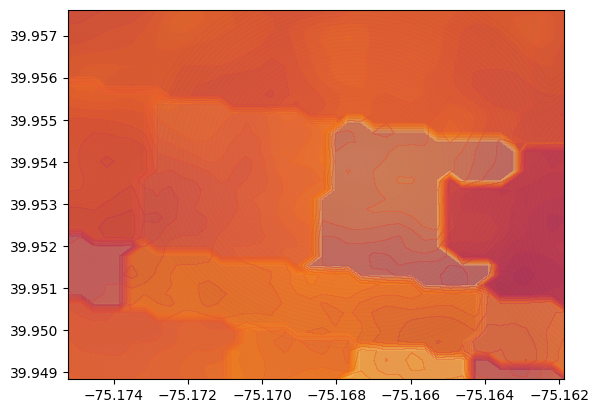

In [48]:
def add_markers(folium_map, gdf, layer_name, col_name, coords=False, max_dist=1000, icon='map-pin', icon_color='lightgray', show=False):
    if coords is not False:
        gdf = cut_bounding_box(coords, gdf, max_dist)
    # Add Coffee shop markers
    group = folium.FeatureGroup(name=f"{layer_name} Markers", show=show).add_to(folium_map)
    # group = MarkerCluster(name=f"{layer_name} Markers").add_to(folium_map)
    gdf_wgs = gdf.to_crs('WGS84')
    for idx, row in gdf_wgs.iterrows():
        folium.Marker(
            location=[row['geometry'].y, row['geometry'].x],
            popup=f"{row[col_name]}" ,
            icon=folium.Icon(color=icon_color, icon=icon, prefix='fa')
        ).add_to(group)

def add_polygons(folium_map, gdf, layer_name):
    group = folium.FeatureGroup(name=f"{layer_name} Polygons", show=False).add_to(folium_map)
    folium.GeoJson(gdf).add_to(group)

def get_colorbar(levels, colormap):
    color_list = []
    cmap = cm.get_cmap('inferno', len(levels))    # PiYG

    for i in range(cmap.N):
        rgba = cmap(i)
        # print(matplotlib.colors.rgb2hex(rgba))
        color_list.append(matplotlib.colors.rgb2hex(rgba))
    step = cmp.StepColormap(
        color_list,
        vmin=vmin, vmax=vmax,
        caption='Colormap for contour maps'
    )
    return step

vmin   = 0
vmax   = 1
levels = list(np.linspace(vmin,vmax,50))
colormap = 'inferno'
x_mesh = lon_grid
y_mesh = lat_grid

geomap = folium.Map([poi_lat, poi_lon], zoom_start=17, tiles="cartodbpositron"
                   , width="50%", height="80%"
                   )
folium.TileLayer('openstreetmap').add_to(geomap)
MousePosition().add_to(geomap)

# Add contour plots for all different scores to the map
for score_name in grid_score_df.columns:
    # Ignore longitude and latitude columns
    if score_name in ['Longitude', 'Latitude']:
        continue
    # Check if current score is overall score
    is_score = True if score_name == 'Score' else False
    
    # Create 2D array from flat arrays
    z_mesh = np.reshape(grid_score_df[score_name].to_numpy(), (x_mesh.shape[0], y_mesh.shape[1]))
    
    # Create contour plot for current score
    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, cmap=colormap, linestyles='None', vmin=vmin, vmax=vmax)
    
    # Create a layer
    group = folium.FeatureGroup(name=f"{score_name} Contour", show=is_score).add_to(geomap)

    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=0.0, # was 3.0
        ndigits=5,
        stroke_width=2,
        fill_opacity=0.5)

    tooltip = folium.GeoJsonTooltip(
        fields=["title"],
        aliases=["Value:"],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )

    # Plot the contour plot on folium
    folium.GeoJson(
        geojson,
        style_function=lambda x: {
            'color':     x['properties']['stroke'],
            'weight':    x['properties']['stroke-width'],
            'fillColor': x['properties']['fill'],
            'opacity':   0.15,
            'fillOpacity': 0.4
        },
        tooltip=tooltip,
        smooth_factor=0 # default is 1.0
    ).add_to(group)
"""
# Add Coffee shop markers
score_marker_group = folium.FeatureGroup(name="Score Markers", show=False).add_to(geomap)
for idx, row in grid_score_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Score: {row['Score']}\n test" ,
    ).add_to(score_marker_group)
    """
add_markers(geomap, bus_gdf, "Bus Stops", 'StopName', coords=grid_coordinates, max_dist=200, icon='bus', icon_color='lightgray')
add_markers(geomap, train_gdf, "Train Stops", 'Station_Na', coords=grid_coordinates, icon='train', icon_color='orange')
add_markers(geomap, coffee_gdf, "Coffeeshops", 'name', coords=grid_coordinates, max_dist=500, icon='mug-saucer', icon_color='black', show=True)
add_markers(geomap, starbucks_gdf, "Starbucks", 'name', coords=grid_coordinates, max_dist=500, icon='mug-saucer', icon_color='blue', show=True)
add_polygons(geomap, park_gdf, "Park")
add_polygons(geomap, university_gdf, "University")
add_polygons(geomap, demography_gdf, "Demography")


group = folium.FeatureGroup(name=f"Potential Location", show=True).add_to(geomap)
folium.Marker(
    location=[poi_lat, poi_lon],
    popup=f"{single_score}" ,
    icon=folium.Icon(color='red', icon='map-pin', prefix='fa')
).add_to(group)


get_colorbar(levels, colormap).add_to(geomap)

#add_markers(geomap, train_gdf, "Train Stops", 'Station_Na', coords=grid_coordinates, icon='train', icon_color='black')
folium.LayerControl().add_to(geomap)
display(geomap)

In [ ]:
geomap.save("index.html")

## Recommend for Starbucks Locations

In [ ]:
coordinates = pd.DataFrame({'Latitude': starbucks_gdf['latitude'], 'Longitude': starbucks_gdf['longitude']})
score_df, data_df = calculate_score(coordinates, ignore_starbucks=True)

## Data Visualizations

In [ ]:
# Load park data
city_gdf = gpd.read_file('/kaggle/input/philadelphia-data/City_Limits.geojson')
#city_gdf = park_gdf.to_crs(projected_crs) # Project in plain coordinate system

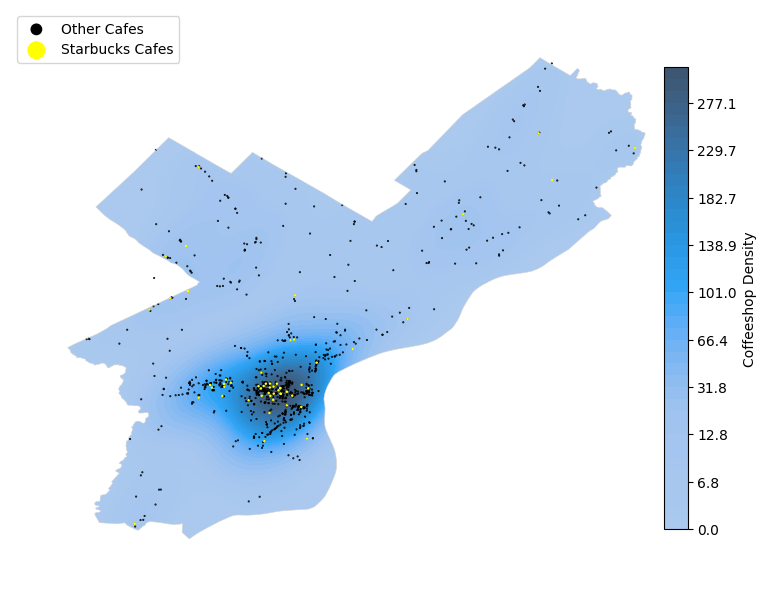

In [54]:
# Plot the KDE plot
ax = geoplot.kdeplot(coffee_gdf.to_crs('WGS84'), fill=True, clip=city_gdf.geometry,
                     n_levels=40, gridsize=200,
                     cbar=True, figsize=(8, 8), thresh=0.0, cbar_kws={'shrink': 0.6, 'pad': -0.05, 'aspect': 20, 'label': 'Coffeeshop Density'}, zorder=1)
# Plot all businesses in white
#geoplot.pointplot(business_gdf.to_crs('WGS84'), ax=ax, s=0.1, color='white', label='All Businesses', zorder=2)

# Plot other cafes in black
geoplot.pointplot(coffee_gdf.to_crs('WGS84'), ax=ax, s=0.5, color='black', label='Other Cafes', zorder=3)

# Plot Starbucks cafes in yellow
geoplot.pointplot(starbucks_gdf.to_crs('WGS84'), ax=ax, s=0.8, color='yellow', label='Starbucks Cafes', zorder=4)

# Plot city boundaries
geoplot.polyplot(city_gdf.to_crs('WGS84'), ax=ax, linewidth=0.4, zorder=5, edgecolor='lightgrey')

ax.set_axis_off()
# Add legend with increased point size
plt.legend(markerscale=15)  # Adjust the markerscale as needed
#ax.set_axis_on()
# Adjust layout
plt.tight_layout()
plt.savefig(f'/kaggle/working/kde_coffeeshops.pdf', bbox_inches='tight')
# Show the plot
plt.show()


In [ ]:
def polyplot_geoplot(gdf, col_name, save=False):
    ax = geoplot.choropleth(
        gdf.to_crs('WGS84'), hue=col_name,
        edgecolor='white', linewidth=0.2,
        cmap='Blues', legend=True, legend_kwargs={
                             'orientation': 'horizontal',
                             'shrink': 0.6, 'pad': -0.05, 'aspect': 30}
    )
    geoplot.polyplot(city_gdf.to_crs('WGS84'), ax=ax, linewidth=0.4, zorder=2, edgecolor='lightgrey')
    ax.set_axis_off()
    plt.tight_layout()
    if save:
        plt.savefig(f'/kaggle/working/{col_name}.pdf', bbox_inches='tight')


polyplot_geoplot(demography_gdf, 'pop_density_normalized', save=True)
polyplot_geoplot(demography_gdf, 'pop_young_perc_normalized', save=True)
polyplot_geoplot(demography_gdf, 'median_household_income_normalized', save=True)
polyplot_geoplot(demography_gdf, 'normalized_average', save=True)

/opt/conda/lib/python3.10/site-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
/opt/conda/lib/python3.10/site-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


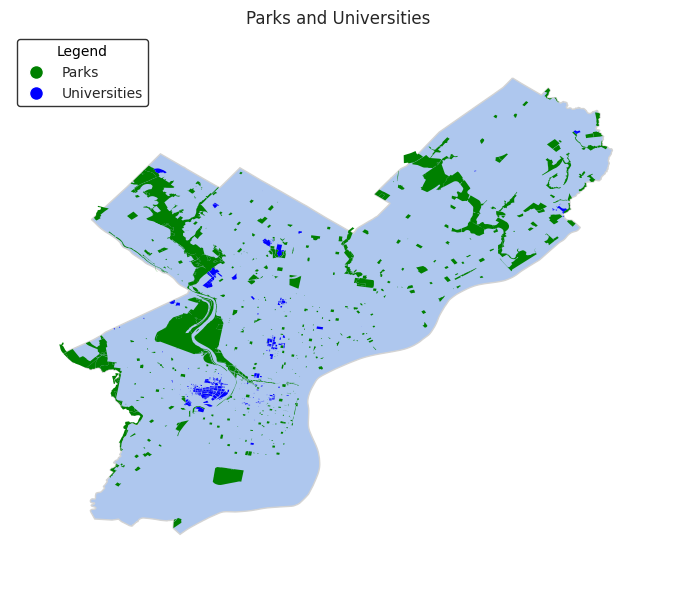

In [104]:
import geopandas as gpd
import geoplot
import matplotlib.pyplot as plt

# Assuming you have already defined park_gdf, university_gdf, and city_gdf

# Create a Matplotlib axis
ax = geoplot.polyplot(park_gdf.to_crs('WGS84'), linewidth=0.1, zorder=2, edgecolor='None', facecolor='green')
geoplot.polyplot(university_gdf.to_crs('WGS84'), ax=ax, linewidth=0.1, zorder=3, edgecolor='None', facecolor='blue')
geoplot.polyplot(city_gdf.to_crs('WGS84'), ax=ax, linewidth=1, zorder=1, edgecolor='lightgrey', facecolor='#aec7ee')

# Set the axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Parks and Universities')

# Add legend with a thinner black border, moved to the top right
legend_labels = {'Parks': 'green', 'Universities': 'blue'}
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in legend_labels.items()]
legend = ax.legend(handles=handles, title='Legend', loc='upper left', frameon=True, edgecolor='black')

# Set the color of the legend title
legend.get_title().set_color('black')

# Save the plot
plt.tight_layout()
plt.savefig('/kaggle/working/parks_universities.pdf', bbox_inches='tight')


/tmp/ipykernel_32/3585356770.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


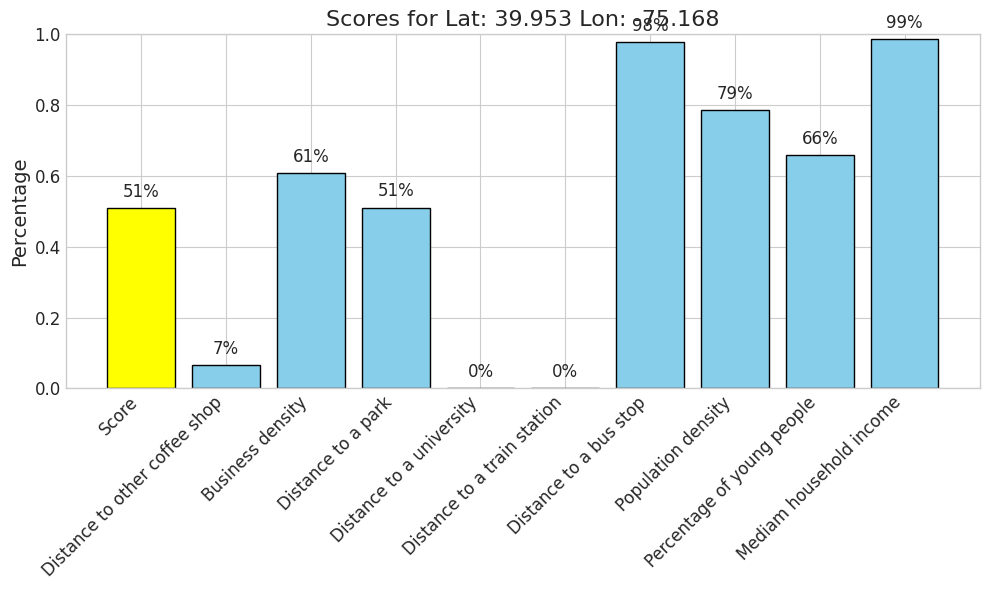

In [78]:
# Sample data
labels = ["Score",
    "Distance to other coffee shop",
          "Business density",
          "Distance to a park", 
          "Distance to a university",
          "Distance to a train station",
          "Distance to a bus stop",
          "Population density",
          "Percentage of young people", 
          "Mediam household income"]
values = score_df[["Score","Competitor Distance", "Business Density", "Park Distance",
                    "University Distance", "Train Distance", "Bus Distance",
                    "Pop Density", "Pop Age", "Income"]].loc[0,:].to_list()

# Set the plot style for a modern look
plt.style.use('seaborn-whitegrid')

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['yellow'] + ['skyblue'] * (len(values) - 1)
bars = ax.bar(np.arange(len(labels)), values, color=colors, edgecolor='black')

# Add data labels above the bars
for bar, label in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{label:.0%}', ha='center', va='bottom', fontsize=12)

# Set x-axis labels
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)

# Set y-axis limits to 1.0
ax.set_ylim([0, 1.0])

# Set axis labels and title
ax.set_ylabel('Percentage', fontsize=14)
#ax.set_xlabel('Categories', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
plt.title(f'Scores for Lat: {poi_lat:.3f} Lon: {poi_lon:.3f}', fontsize=16)

# Display the plot
plt.tight_layout()
plt.savefig(f'/kaggle/working/score_bar_plot.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

pie_df = pd.DataFrame(
{"score_col_name": ["Competitor Distance", "Business Density", "Park Distance",
                    "University Distance", "Bus Distance", "Train Distance",
                    "Pop Density", "Pop Age", "Income"],
"data_col_name": ["Competitor Distance", "Business Density", "Park Distance",
                    "University Distance", "Bus Distance", "Train Distance",
                    "pop_density_normalized", "pop_young_perc_normalized", "median_household_income_normalized"],
"names": ["Distance to a competing coffee shop",
          "Business density",
          "Distance to a park", 
          "Distance to a university",
          "Distance to a bus stop",
          "Distance to a train station",
          "Population density",
          "Percentage of young people", 
          "Mediam household income"],
"unit": ["m",
          "",
          "m", 
          "m",
          "m",
          "m",
          "",
          "", 
          ""]})


data = score_df.drop(["Latitude", "Longitude", "Score"], axis=1).loc[0, :].to_list()
display(data)

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f"{pie_df['names'][i]} (Score: {score_df[pie_df['score_col_name'][i]][0]:.2f}, Value: {data_df[pie_df['data_col_name'][i]][0]:.2f}{pie_df['unit'][i]})", xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title(" ")

plt.show()

#### Coffeeshop Heatmap

In [ ]:
import folium

from folium.plugins import HeatMap

heat_map = folium.Map([40, -75], zoom_start=10)

heat_coords = coffee_df[['latitude', 'longitude']]
folium.plugins.HeatMap(heat_coords).add_to(heat_map)
MousePosition().add_to(heat_map)

heat_map

### Parks

In [ ]:
# Opening JSON file
f = open('/kaggle/input/philadelphia-data/PPR_Properties.geojson')
geo_json_data = json.load(f)
m = folium.Map([40, -75], zoom_start=10)

folium.GeoJson(geo_json_data).add_to(m)

m

### Demographics

In [ ]:
ax = geoplot.kdeplot(coffee_gdf.to_crs('WGS84'), fill=True, clip=city_gdf.geometry,
                     n_levels=20,cbar=True, figsize=(6, 6), thresh=0.0, cbar_kws={'shrink': 0.6, 'pad': -0.05})
geoplot.pointplot(coffee_gdf.to_crs('WGS84'),ax=ax, s=0.5, color='black')
geoplot.polyplot(city_gdf.to_crs('WGS84'), ax=ax, linewidth=1, zorder=2)
plt.tight_layout()
plt.show()

----------------------------------------------------------------------------------------------------
## Playground

In [ ]:
import geopandas as gpd
from scipy.stats import gaussian_kde
import numpy as np

# Assuming your GeoPandas DataFrame is named 'gdf' and has a geometry column named 'geometry'
# Replace 'your_latitude' and 'your_longitude' with the coordinates of your arbitrary point

# Example GeoPandas DataFrame
# gdf = ...

# Example arbitrary point
